# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce
import datetime

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Get all the Data, Build all the Graphs

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
science_repo_sql = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                    --science 
                    SELECT
                    	repo_git, ntile(4) over ( order by commits_all_time) 
                    FROM
                    	repo A,
                    	(
                    	SELECT C.repo_id, d.commits_all_time
                    	FROM
                    		augur_operations.users A,
                    		augur_operations.user_groups b,
                    		augur_operations.user_repos C, 
                    		api_get_all_repos_commits d 
                    	WHERE
                    		A.user_id = b.user_id 
                    		AND b.group_id = C.group_id 
                    		AND d.repo_id= c.repo_id
                    		AND b.NAME = 'Google' --AND lower(A.login_name)='numfocus'
                    		
                    	ORDER BY
                    		A.login_name,
                    		d.commits_all_time,
                    		b.group_id 
                    	) b 
                    WHERE
                    	A.repo_id = b.repo_id order by commits_all_time desc
                            """)

with engine.connect() as conn:
    #df = pd.read_sql(sql, cnxn)
    results = conn.execute(science_repo_sql)
    df_results = pd.DataFrame(results) 

print(df_results)

                                               repo_git  ntile
0                       https://github.com/google/kmsan      4
1                https://github.com/google/ghost-kernel      4
2              https://github.com/google/capsicum-linux      4
3          https://github.com/google/intellij-community      4
4                https://github.com/google/llvm-project      4
...                                                 ...    ...
2466   https://github.com/google/sgtm-event-data-filter      1
2467          https://github.com/google/gos-conventions      1
2468    https://github.com/google/swift-package-manager      1
2469      https://github.com/google/explaining-in-style      1
2470  https://github.com/google/intellij-cmdline-vcs...      1

[2471 rows x 2 columns]


,repo_git,ntile
0,https://github.com/google/kmsan,4
1,https://github.com/google/ghost-kernel,4
2,https://github.com/google/capsicum-linux,4
3,https://github.com/google/intellij-community,4
4,https://github.com/google/llvm-project,4
...,...,...
2466,https://github.com/google/sgtm-event-data-filter,1
2467,https://github.com/google/gos-conventions,1
2468,https://github.com/google/swift-package-manager,1
2469,https://github.com/google/explaining-in-style,1


array([1, 2, 3, 4])

Graphs for NTILE: 1
Starting Data Collection for NTILE: 1
current time:- 2023-07-06 19:16:27.631059
Graphs for NTILE: 1
Finished itertuples for NTILE: 1
current time:- 2023-07-06 19:19:36.958717
(55560,53625,53258,54182,54585,55706,53523,54205,54611,53364,53405,53714,55415,54858,55671,54254,54454,54137,54397,54520,55392,55086,55722,54193,54908,55204,54964,53239,54617,54556,53392,54836,53700,55511,55535,54974,55109,53443,55042,53423,55434,53335,54487,53568,54341,54511,53744,55437,53583,55154,55223,53702,55743,54005,54601,53471,54004,54115,55400,54736,53741,53946,55452,55592,53926,53984,54744,54722,54621,55137,53420,54770,55657,53688,53550,53958,55317,55514,53447,54096,54651,53983,54831,53262,55731,53919,55562,54158,53579,55303,54680,53560,54234,54955,54952,54076,55566,53311,54703,55068,53648,53408,55612,55200,54522,55554,55541,54498,55293,53874,55539,55726,55420,53722,54926,53942,54120,54507,54506,54714,55662,54291,54375,55389,55595,55218,54581,55713,55121,54551,55016,54256,54172,55365,

,repo_id,repo_git,cntrb_id,issue_id
0,54858,https://github.com/google/it-cert-automation-p...,01081ccb-0e00-0000-0000-000000000000,17894317
1,53839,https://github.com/google/http2preload,01011449-ae00-0000-0000-000000000000,9903426
2,54896,https://github.com/google/ukip,01035883-3300-0000-0000-000000000000,9903545
3,53839,https://github.com/google/http2preload,010002bc-b800-0000-0000-000000000000,9903427
4,53839,https://github.com/google/http2preload,01000063-3d00-0000-0000-000000000000,9903428
...,...,...,...,...
3935,55679,https://github.com/google/dreambooth,01010d99-2600-0000-0000-000000000000,9903397
3936,55325,https://github.com/google/explaining-in-style,01009cae-7200-0000-0000-000000000000,9903494
3937,55325,https://github.com/google/explaining-in-style,0102d4bf-f500-0000-0000-000000000000,9903495
3938,53702,https://github.com/google/java-sourcetools,010092b5-a700-0000-0000-000000000000,9903316


Graphs for NTILE: 1
Ending Data Collection for ISSUES in NTILE: 1
current time:- 2023-07-06 19:19:37.493587


,repo_id,repo_git,cntrb_id,pull_request_id
0,55743,https://github.com/google/project-gameface,0100037f-e800-0000-0000-000000000000,13678522
1,53554,https://github.com/google/appspeedindex,010183c8-dd00-0000-0000-000000000000,13676051
2,54530,https://github.com/google/graph-gen,0100081f-4200-0000-0000-000000000000,13676105
3,54530,https://github.com/google/graph-gen,0100147a-3400-0000-0000-000000000000,13676105
4,54858,https://github.com/google/it-cert-automation-p...,0104e058-4c00-0000-0000-000000000000,14030084
...,...,...,...,...
62950,54858,https://github.com/google/it-cert-automation-p...,0100147a-3400-0000-0000-000000000000,14050339
62951,53557,https://github.com/google/touchtime,01023799-6100-0000-0000-000000000000,13676052
62952,55666,https://github.com/google/tekton-slsa-demo,01005f33-ad00-0000-0000-000000000000,13676160
62953,55303,https://github.com/google/deluca-igpc,0100147a-3400-0000-0000-000000000000,13676135


Graphs for NTILE: 1
Ending Data Collection for PULL REQUESTS in NTILE: 1
current time:- 2023-07-06 19:19:38.785807


,repo_id,repo_git,cntrb_id,pull_request_id
0,54291,https://github.com/google/teknowledge,010032b7-be00-0000-0000-000000000000,13676095
1,54985,https://github.com/google/vbootrom,01000144-5100-0000-0000-000000000000,13676296
2,54985,https://github.com/google/vbootrom,01000144-5100-0000-0000-000000000000,13676296
3,55415,https://github.com/google/sxg-validator,0100000b-4d00-0000-0000-000000000000,13678745
4,55415,https://github.com/google/sxg-validator,0100000b-4d00-0000-0000-000000000000,13678745
...,...,...,...,...
1158,54858,https://github.com/google/it-cert-automation-p...,010740ba-e400-0000-0000-000000000000,25739977
1159,54858,https://github.com/google/it-cert-automation-p...,0104aa3a-1c00-0000-0000-000000000000,25739977
1160,54858,https://github.com/google/it-cert-automation-p...,0104aa3a-1c00-0000-0000-000000000000,25739977
1161,54858,https://github.com/google/it-cert-automation-p...,01080113-9800-0000-0000-000000000000,25739977


Graphs for NTILE: 1
Ending Data Collection for PR REVIEWERS in NTILE: 1
current time:- 2023-07-06 19:19:40.263702


,repo_id,repo_git,cntrb_id,cmt_id
0,55097,https://github.com/google/plusfish,010011dc-a200-0000-0000-000000000000,163157968
1,55097,https://github.com/google/plusfish,010011dc-a200-0000-0000-000000000000,163157722
2,55097,https://github.com/google/plusfish,010011dc-a200-0000-0000-000000000000,163157725
3,55097,https://github.com/google/plusfish,010011dc-a200-0000-0000-000000000000,163157728
4,55097,https://github.com/google/plusfish,010011dc-a200-0000-0000-000000000000,163157730
...,...,...,...,...
128729,55353,https://github.com/google/web-prototyping-tool,01013145-5600-0000-0000-000000000000,163169744
128730,55353,https://github.com/google/web-prototyping-tool,01013145-5600-0000-0000-000000000000,163169746
128731,55353,https://github.com/google/web-prototyping-tool,01013145-5600-0000-0000-000000000000,163169748
128732,55353,https://github.com/google/web-prototyping-tool,01013145-5600-0000-0000-000000000000,163169750


Completed ALL Data Collection for NTILE: 1
current time:- 2023-07-06 19:20:01.149525
commit contributor graph


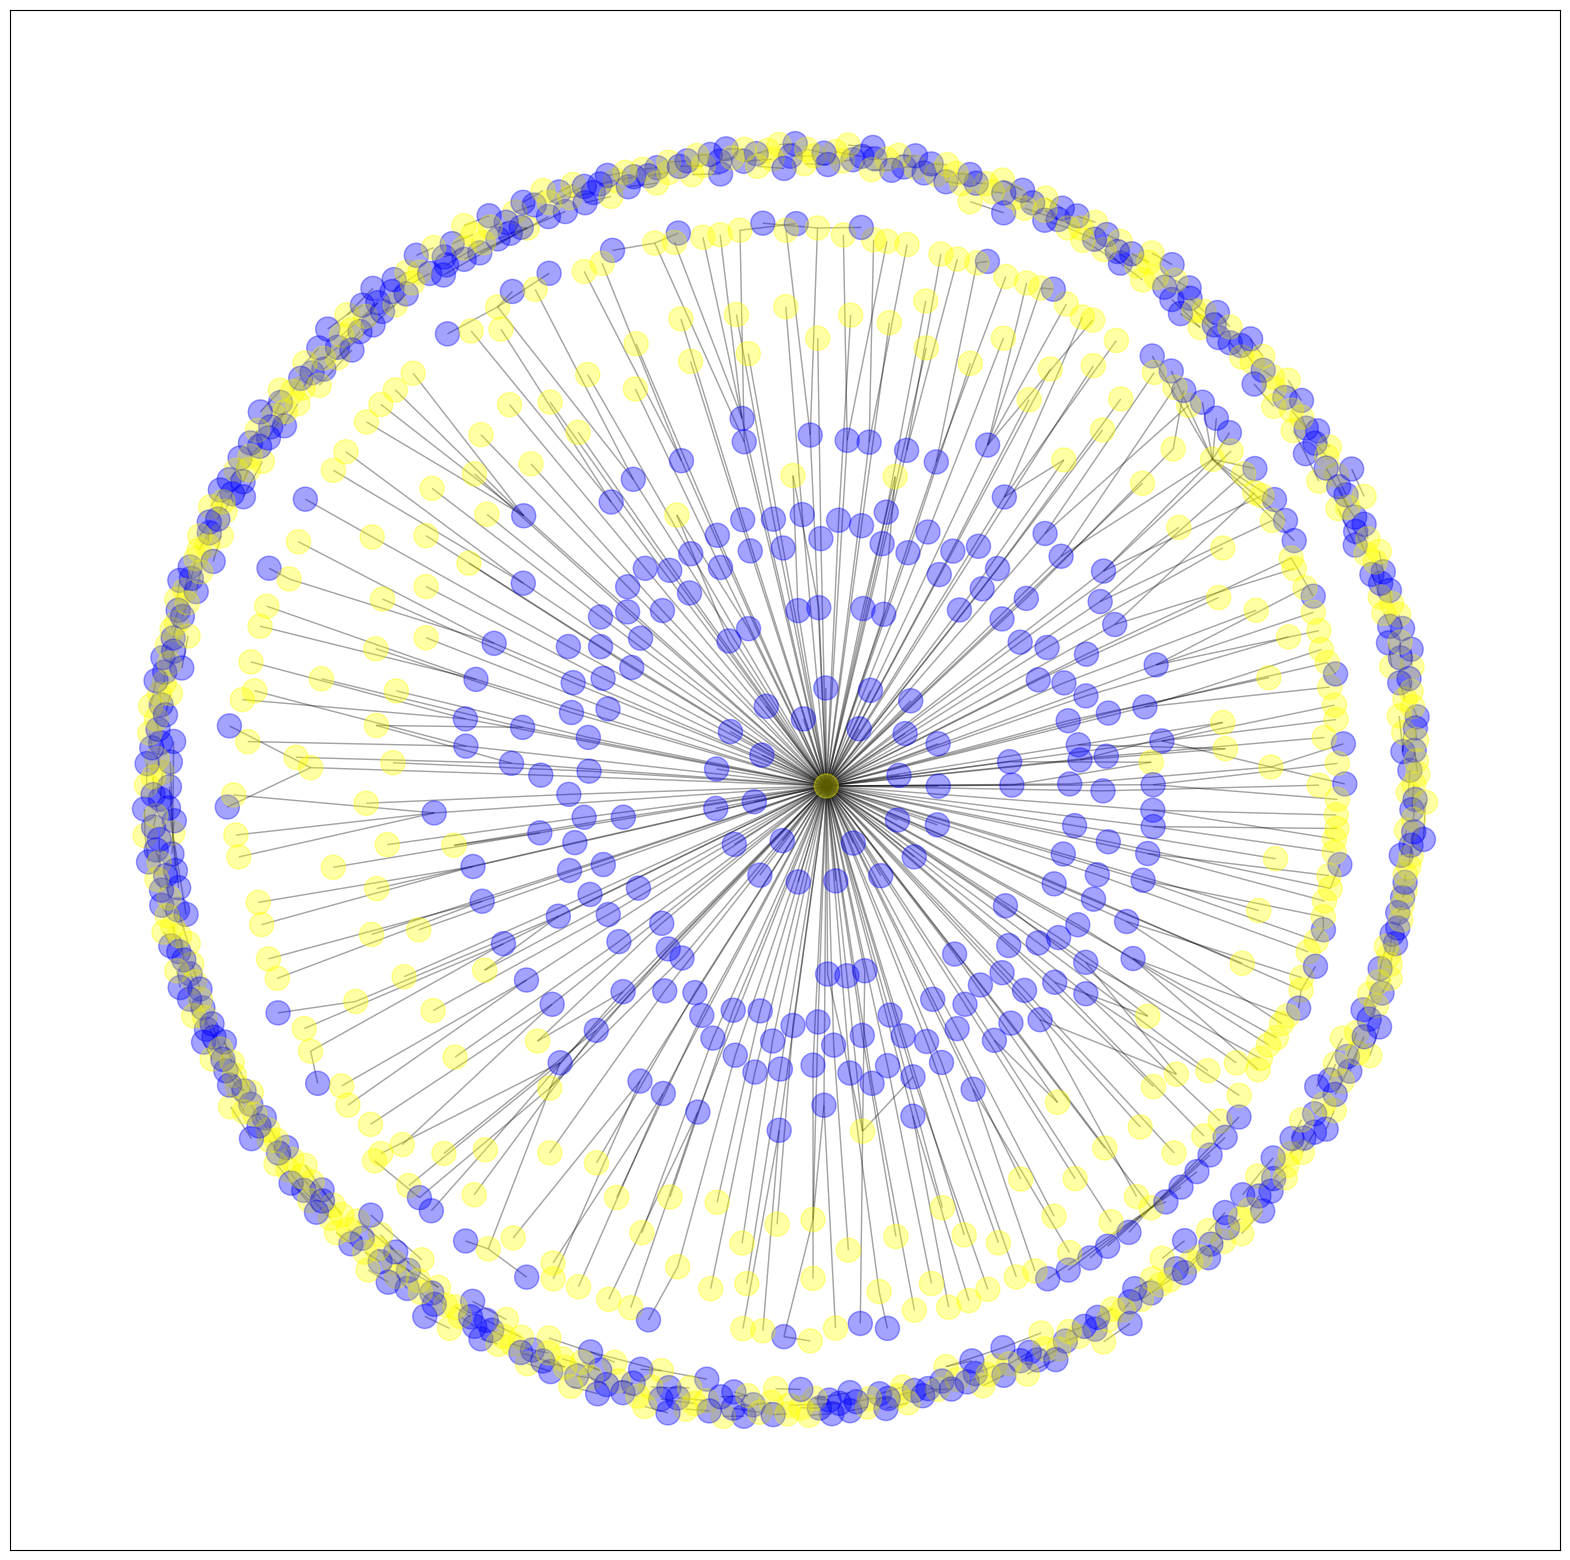

Graph for commit contributors should have just printed
current time:- 2023-07-06 19:20:12.346738
issue contributor graph


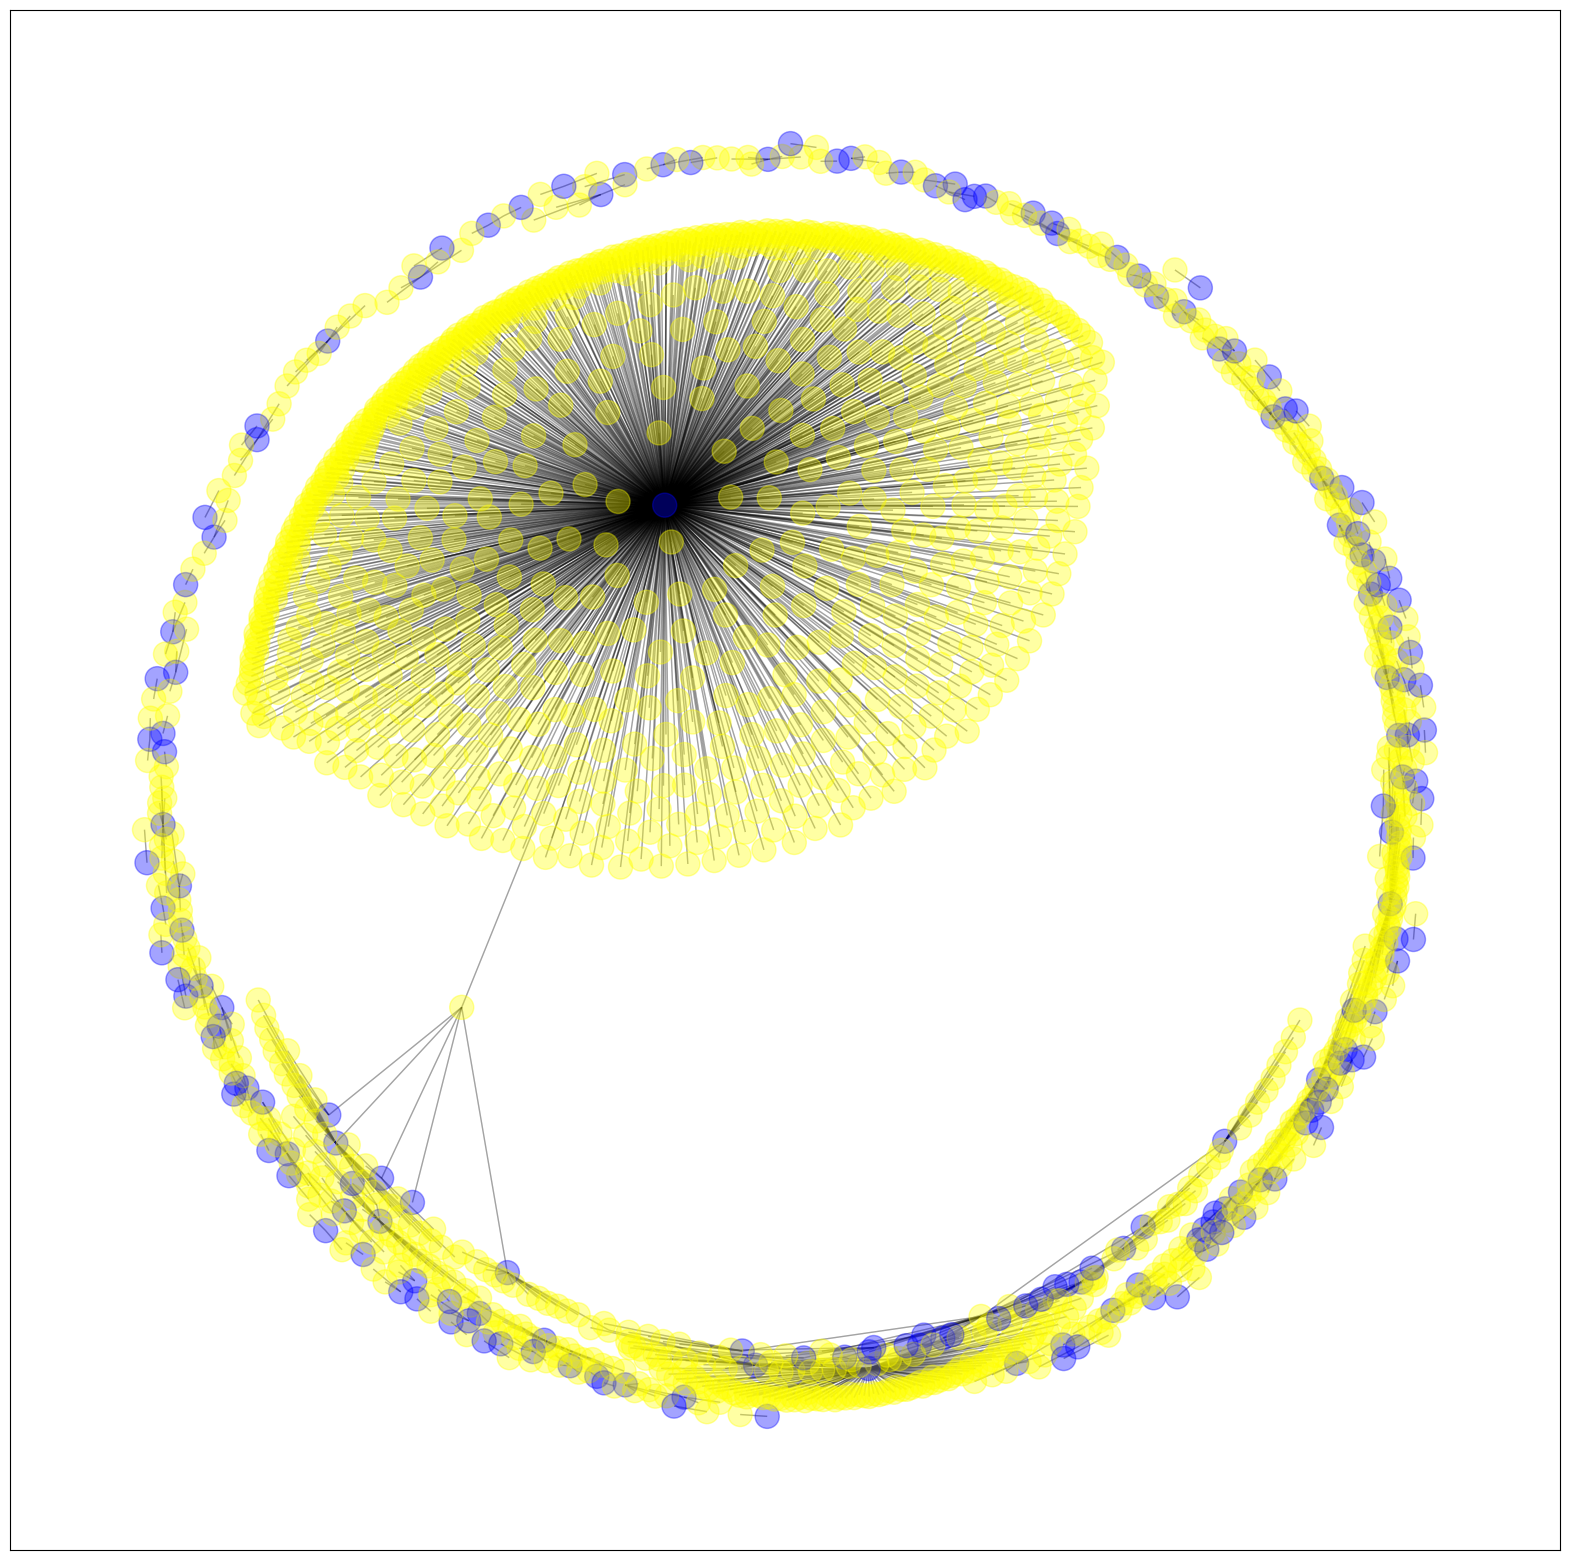

Graph for issue contributors should have just printed
current time:- 2023-07-06 19:20:32.873529


In [ ]:
#find unique ntile values
ntiles = df_results.ntile.unique()
display(df_results) 
#sort values smallest to largest
ntiles.sort()

#display sorted values
display(ntiles)

#run analysis in ntiles
#surveys_df[surveys_df.year == 2002]

for i in ntiles:
    repo_set=[]
    repo_git_set = []
    repo_name_set = []
    result_tile = df_results[df_results.ntile==i]
    #print(i)
    #print(result_tile)

    
    print("Graphs for NTILE: " + str(i))
    print('Starting Data Collection for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

#    for index, row in result_tile.iterrows():
    for row in result_tile.itertuples(index = True):
        trepo_git=getattr(row,"repo_git")
        #fdisplay(trepo_git)
        
        repo_query = salc.sql.text(f"""
                     SET SCHEMA 'augur_data';
                     SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{trepo_git}'
            """)
        with engine.connect() as conn:
            results = conn.execute(repo_query)
            df2_results = pd.DataFrame(results) 
        df2_results.reset_index(drop=True, inplace=True) 
        repo_id = int(df2_results['repo_id'].values[0])
        repo_name = df2_results['repo_name'].to_string(index=False)
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)
        repo_git_set.append(trepo_git)    

    print("Graphs for NTILE: " + str(i))
    print('Finished itertuples for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

    repo_all = '('
    
    for repo_id in repo_set:
        repo_all = repo_all + str(repo_id) + ','
    
    repo_all = repo_all.rstrip(repo_all[-1])
        
    repo_all = repo_all + ')'
    print(repo_all)

    #Issue Contributors
    issue_contrib = pd.DataFrame()
    #for repo_id in repo_set:
        
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                i.reporter_id as cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id in {repo_all} AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])
    
    issue_contrib = issue_contrib.reset_index()
    issue_contrib.drop("index", axis=1, inplace=True)
    issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
    display(issue_contrib)
    #issue_contrib.dtypes   
    
    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for ISSUES in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)
        
    #PR Contributors
    pr_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id in {repo_all} AND
                prm.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])
    
    pr_contrib = pr_contrib.reset_index()
    pr_contrib.drop("index", axis=1, inplace=True)
    pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
    display(pr_contrib)
    #pr_contrib.dtypes

    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for PULL REQUESTS in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)


    #PR Reviewers
    prr_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id in {repo_all} AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])
    
    prr_contrib = prr_contrib.reset_index()
    prr_contrib.drop("index", axis=1, inplace=True)
    prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
    display(prr_contrib)
    #prr_contrib.dtypes
    
    print("Graphs for NTILE: " + str(i))
    print('Ending Data Collection for PR REVIEWERS in NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

    # Commit Contributors
    commit_contrib = pd.DataFrame()
    
    #for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id in {repo_all} AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])
    
    commit_contrib = commit_contrib.reset_index()
    commit_contrib.drop("index", axis=1, inplace=True)
    commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
    display(commit_contrib)
    #commit_contrib.dtypes


###########################################################################

    print('Completed ALL Data Collection for NTILE: ' + str(i))
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    # Commit Contributor Graph
    df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_commit.head()
    df_commit = df_commit.reset_index()
    
    df_melted_commit = df_commit.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')
    
    df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
    df_melted_commit.head()
    G = nx.from_pandas_edgelist(df_melted_commit, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    Repo_id = df_melted_commit['repo_id'].to_list()
    contributor_id = df_melted_commit['cntrb_id'].to_list()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    #yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
    #blue_patch = mpatches.Patch(color='blue', label='Repository')
    #ax.legend(handles=[yellow_patch, blue_patch])
    print('commit contributor graph')
  

    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "commit_contributor_graph_ntile_corp" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    #nx.draw_networkx(G, node_color=colors, with_labels=False, font_size=8, ax=ax)
    print('Graph for commit contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    # Issue Contributor Graph
    df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_issue = df_issue.reset_index()
    df_melted_issue = df_issue.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]

    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_issue, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())
    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]
    fig, ax = plt.subplots(figsize=(20,20))
    #ax.legend(handles=[yellow_patch, blue_patch])
    print('issue contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "issue_contributor_graph_ntile_corp" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   

    
    print('Graph for issue contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################
    
    ### PR Contributor Graph
    df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_pr = df_pr.reset_index()
    df_melted_pr = df_pr.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_pr, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())

    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.fruchterman_reingold_layout(G)
    print('PR contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "PR_contributor_graph_ntile_corp" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    print('Graph for PR contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)

####################################################################

    ### PR REVIEWER Contributor Graph
    df_pr = prr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
    df_pr = df_pr.reset_index()
    df_melted_pr = df_pr.melt(
        ['repo_id'],
        var_name = 'cntrb_id',value_name='number')

    df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
    Repo_id = df_melted_issue['repo_id'].to_list()
    contributor_id = df_melted_issue['cntrb_id'].to_list()
    
    G = nx.from_pandas_edgelist(df_melted_pr, 
                                source='repo_id',
                                target='cntrb_id',
                                edge_attr='number',
                                create_using=nx.MultiGraph())

    nodes = G.nodes()
    colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

    fig, ax = plt.subplots(figsize=(20,20))
    pos = nx.fruchterman_reingold_layout(G)
    print('PR REVIEW contributor graph')


    pos = nx.fruchterman_reingold_layout(G)
    spos = nx.spring_layout(G, pos=pos, k=.4)
    anonygraph = nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)
    filename = "PR_contributor_graph_ntile_corp" + str(i) +".png"
    plt.savefig(fname=filename, format="png")
    plt.show(nx.draw_networkx(G, node_color=colors, pos=spos, with_labels=False, alpha=0.2, font_size=7, ax=ax))
    nx.draw_networkx(G, node_color=colors, with_labels=False, pos=spos, alpha=0.2, font_size=7, ax=ax)   
    
    print('Graph for PR REVIEW contributors should have just printed')
    ct = datetime.datetime.now()
    print("current time:-", ct)